Use the [updated version now on github](https://colab.research.google.com/github/hgbrian/biocolabs/blob/master/DiffDock.ipynb).

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

v3:
- fix py3dmol incompatibility
- downgrade pytorch since the colab version takes forever to install pytorch_geometric (no binary so it has to compile)
THIS MEANS YOU HAVE TO RUN ALL TWICE!

v4:
- replace smina with the more accurate gnina
- remove the annoying run twice thing now there is a binary

colab by [@btnaughton](https://twitter.com/btnaughton)

In [ ]:
#@title PDB + SMILES input

PDB_id = '4G5J' #@param {type:"string"}
SMILES_or_pubchem_id = '60147041' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

In [ ]:
# The default version of colab takes forever to install pytorch_geometric
# For now, downgrade (which requires restarting runtime :( )
#import os
#import torch
#if torch.__version__[:6] != "1.13.1":
#    !pip uninstall torch torchaudio torchdata torchtext torchvision fastai --y
#    !pip install torch==1.13.1
#    os.kill(os.getpid(), 9)

In [ ]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [ ]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

In [ ]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

## Install prerequisites

In [ ]:
!pip install ipython-autotime --quiet
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
time: 350 µs (started: 2024-05-13 13:31:51 +00:00)


In [ ]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

/content
Cloning into 'DiffDock'...
remote: Enumerating objects: 473, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 473 (delta 182), reused 233 (delta 139), pack-reused 148
Receiving objects: 100% (473/473), 233.08 MiB | 13.84 MiB/s, done.
Resolving deltas: 100% (211/211), done.
/content/DiffDock
Updating files: 100% (116/116), done.
Note: switching to 'a6c5275'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at a6c5275 remove debugging rais

In [ ]:
try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 84.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.3 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.22.4 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 1.22.4 which is incompatible.
jax 0.4.26 requires scipy>=1.9, but you have scipy 1.7.3 which is incompati

In [ ]:
import torch
print(torch.__version__)

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 72.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
time: 48 s (started: 2024-05-13 13:34:51 +00:00)


## Install ESM and prepare PDB file for ESM

In [ ]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

/content/DiffDock
Cloning into 'esm'...
remote: Enumerating objects: 1511, done.
remote: Counting objects: 100% (1511/1511), done.
remote: Compressing objects: 100% (579/579), done.
remote: Total 1511 (delta 950), reused 1316 (delta 914), pack-reused 0
Receiving objects: 100% (1511/1511), 13.25 MiB | 9.69 MiB/s, done.
Resolving deltas: 100% (950/950), done.
/content/DiffDock/esm
Note: switching to 'ca8a710'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ca8a710 Update version.py (#310)
Obtaining file:///conte

In [ ]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/content/DiffDock
100% 1/1 [00:00<00:00, 15.62it/s]
time: 1.01 s (started: 2024-05-13 13:36:04 +00:00)


In [ ]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Transferred model to GPU
Read data/prepared_for_esm.fasta with 1 sequences
Processing 1 of 1 batches (1 sequences)
time: 39.3 s (started: 2024-05-13 13:36:05 +00:00)


## Run DiffDock

In [ ]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
100% 201/201 [00:44<00:00,  4.47it/s]
100% 201/201 [01:07<00:00,  2.96it/s]
/content/DiffDock/utils/torus.py:38: RuntimeWarning: invalid value encountered in true_divide
  score_ = grad(x, sigma[:, None], N=100) / p_
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00, 13.87it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 1/1 [00:00<00:00,  3.13it/s]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings3632373731/heterographs.pkl
Number of complexes:  1
radius protein: mean 35.39956283569336, std 0.0, max 35.39956283569336
radius molecule: mean 8.566842079162598, std 0.0, max 8.566842079162598
distance protein-mol: mean 64.07469177246094, std 0.0, max 64.07469177246094
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing

# Post-process and download results

In [ ]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina
!wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina -O gnina && chmod +x gnina

/content/DiffDock
--2024-05-13 13:44:01--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.12.149|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABmQhkiSY0GLYxl4FNzSoQntkqPxSivzErFCIWmvTvQ317LlpaRc4AIVsGIrxr30nmNHzaTpIyozSGC8TL0EuNz9W9Ttw%3D%3D&use_mirror=nchc&r= [following]
--2024-05-13 13:44:02--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABmQhkiSY0GLYxl4FNzSoQntkqPxSivzErFCIWmvTvQ317LlpaRc4AIVsGIrxr30nmNHzaTpIyozSGC8TL0EuNz9W9Ttw%3D%3D&use_mirror=nchc&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found


In [ ]:
!./gnina --version

gnina  master:e9cb230+   Built Feb 11 2023.
time: 104 ms (started: 2024-05-13 13:44:08 +00:00)


In [ ]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/gnina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/gnina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

#
# create dataframe, tar file and download
#
df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "gnina_scored_affinity", "gnina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv}

    files.download(f"{tarname}.tar")

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 1min 4s (started: 2024-05-13 13:44:08 +00:00)


## Compare gnina affinities with DiffDock confidences

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


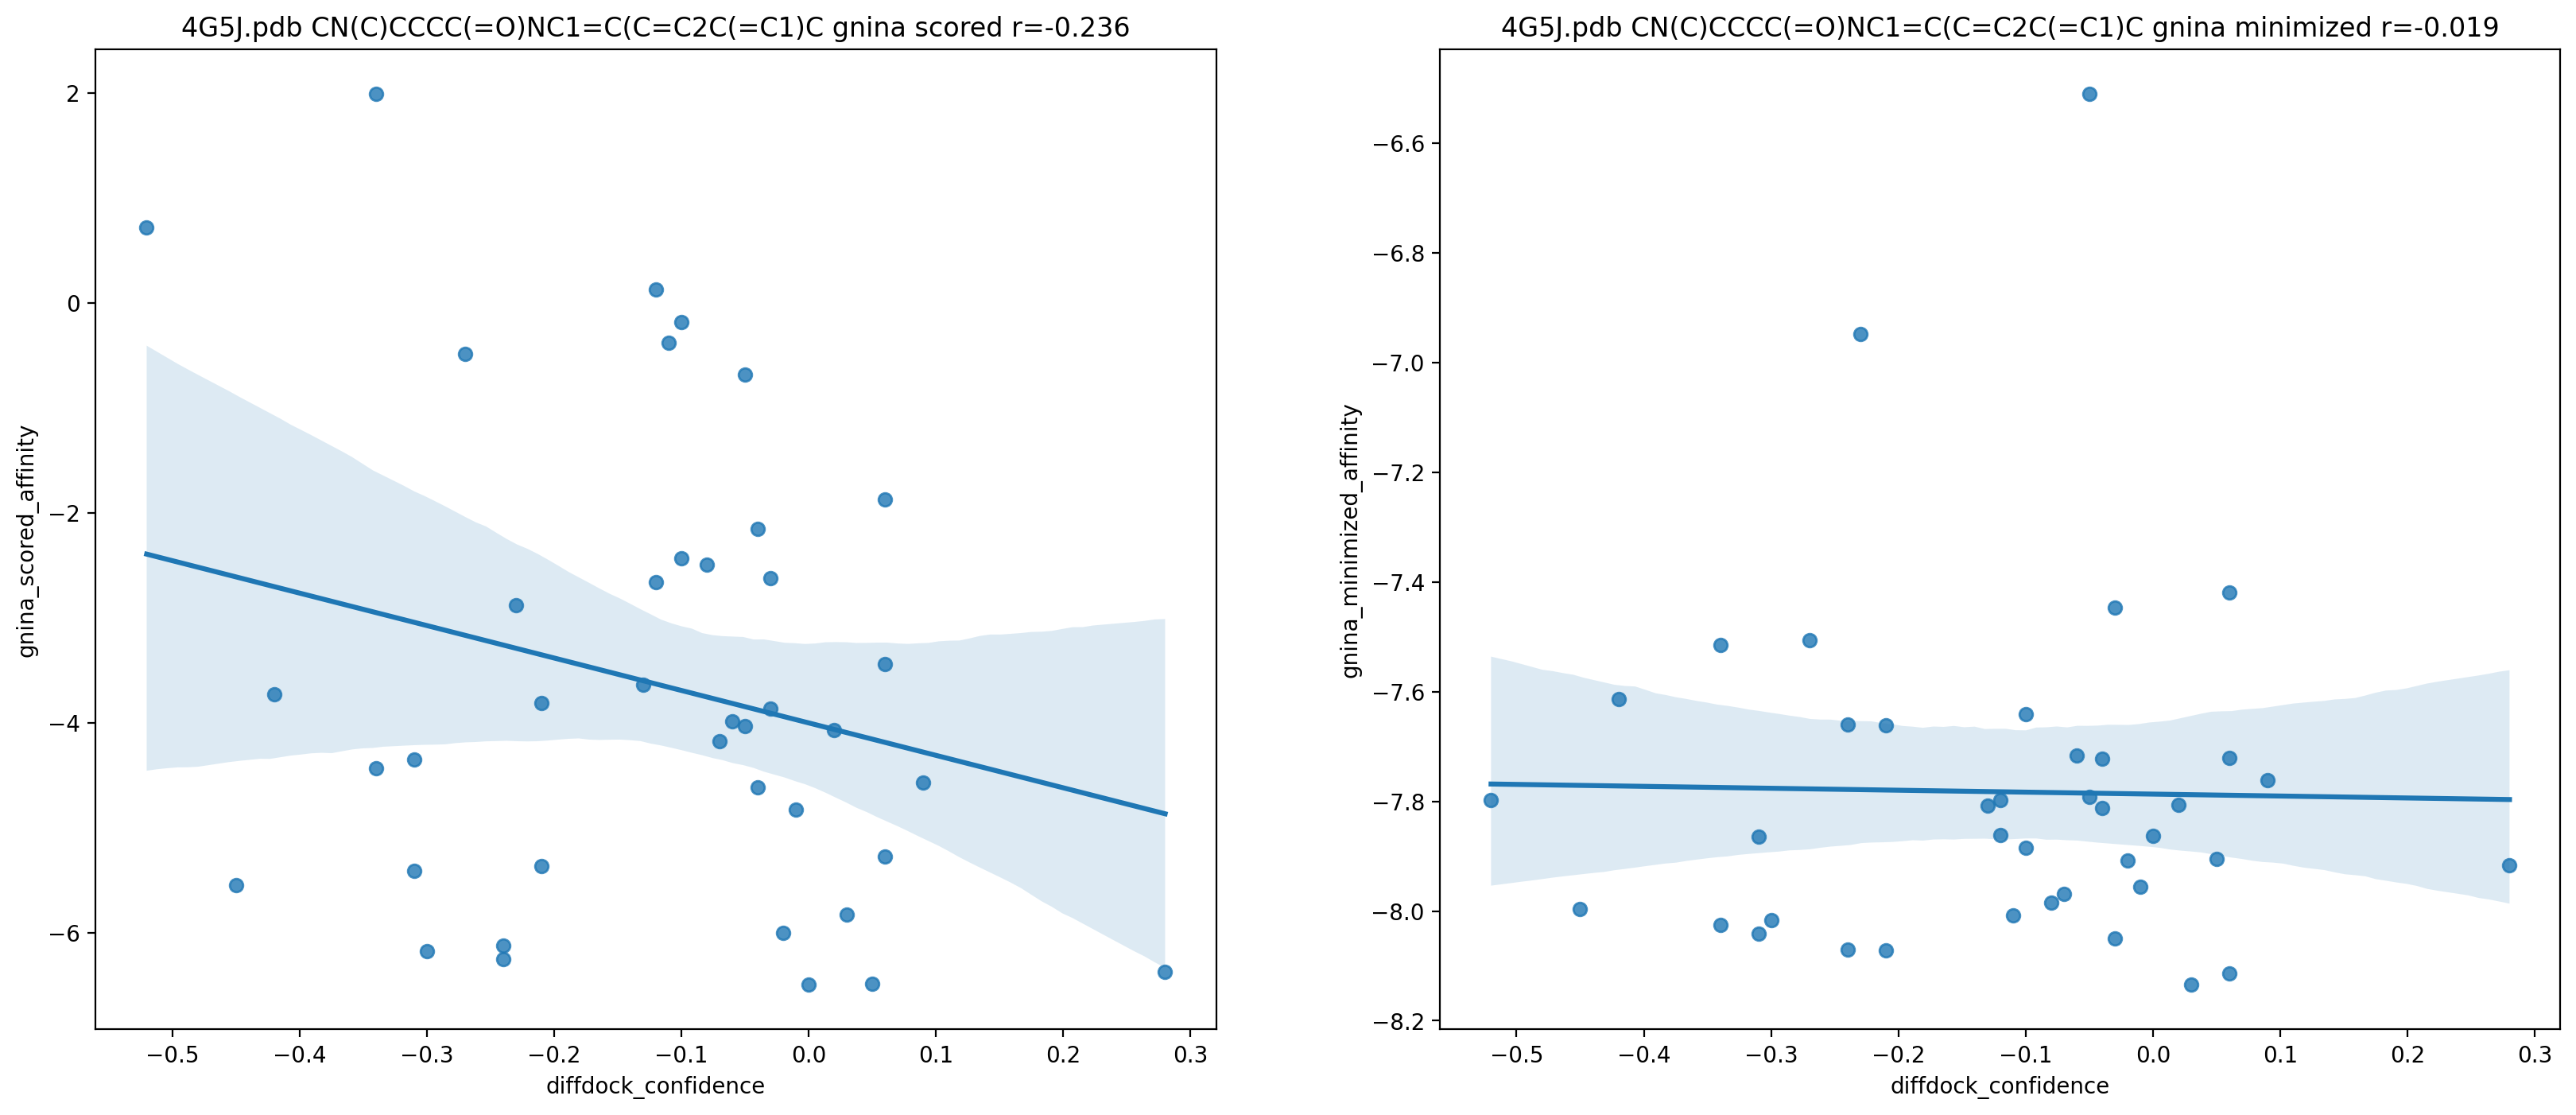

time: 1.71 s (started: 2024-05-13 13:45:13 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} gnina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} gnina minimized r={r_value_minimized:.3f}");

In [ ]:
df_results.sort_values("diffdock_confidence", ascending=False).head(3)

,pdb_file,smiles,diffdock_confidence,gnina_scored_affinity,gnina_minimized_affinity,sdf_file
8,4G5J.pdb,CN(C)CCCC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=...,0.28,-6.37205,-7.91615,./index0_-tmp-pdb-4G5J.pdb____CN(C)CCCC(=O)NC1...
20,4G5J.pdb,CN(C)CCCC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=...,0.09,-4.57065,-7.76076,./index0_-tmp-pdb-4G5J.pdb____CN(C)CCCC(=O)NC1...
36,4G5J.pdb,CN(C)CCCC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=...,0.06,-3.44103,-7.72014,./index0_-tmp-pdb-4G5J.pdb____CN(C)CCCC(=O)NC1...


time: 40 ms (started: 2024-05-13 13:45:14 +00:00)


# Visualize top hit (highest confidence) in 3D

In [ ]:
!pip install py3dmol==2.0.3 --quiet

time: 5.33 s (started: 2024-05-13 13:45:14 +00:00)


In [ ]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});

top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
print("top hit:")
display(top_hit)

view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})



view.addModel(open('rec.pdb').read());
view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})
view.zoomTo();view.addModel(open('lig.pdb').read())
view.setStyle({"model": 2}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 2, "hetflag":True}, {'stick':{"color":"spectrum"}})
model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

top hit:


pdb_file                                                             4G5J.pdb
smiles                      CN(C)CCCC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=...
diffdock_confidence                                                      0.28
gnina_scored_affinity                                                -6.37205
gnina_minimized_affinity                                             -7.91615
sdf_file                    ./index0_-tmp-pdb-4G5J.pdb____CN(C)CCCC(=O)NC1...
Name: 8, dtype: object

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

time: 34.9 ms (started: 2024-05-13 14:01:18 +00:00)


In [ ]:
!wget http://files.rcsb.org/download/4G5J.pdb
!grep ATOM 4G5J.pdb > rec.pdb
!grep 0WN 4G5J.pdb > lig.pdb

In [ ]:
!pip install py3Dmol


time: 6.84 s (started: 2024-05-13 13:55:14 +00:00)


In [ ]:
import py3Dmol
v = py3Dmol.view()

v.addModel(open('lig.pdb').read())
v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon'}})
v.zoomTo({'model':0})

In [ ]:
!apt install openbabel

In [ ]:
import os
import glob
import re
import subprocess
from tqdm import tqdm

os.chdir("/content/DiffDock/results/user_predictions_small")

results_dirs = glob.glob("./index*")


def extract_rank(file_name):

    match = re.search(r'rank(\d+)', file_name)
    if match:
        return int(match.group(1))
    return float('inf')


for results_dir in tqdm(results_dirs, desc="Traitement des répertoires de prédiction"):

    sdf_files = [f for f in os.listdir(results_dir) if f.endswith('.sdf')]


    sdf_files.sort(key=extract_rank)

    for sdf_file_name in sdf_files:
        sdf_file = os.path.join(results_dir, sdf_file_name)


        command = ["obrms", "-f", "lig.pdb", sdf_file]


        result = subprocess.run(command, capture_output=True, text=True)

        print(f"{result.stdout}")


Traitement des répertoires de prédiction:   0%|          | 0/1 [00:00<?, ?it/s]

RMSD lig.pdb: 1.99713

RMSD lig.pdb: 1.99713

RMSD lig.pdb: 0.926168

RMSD lig.pdb: 1.05365

RMSD lig.pdb: 1.02407

RMSD lig.pdb: 0.680015

RMSD lig.pdb: 0.873544

RMSD lig.pdb: 2.10917

RMSD lig.pdb: 1.22877

RMSD lig.pdb: 0.860915

RMSD lig.pdb: 0.989221

RMSD lig.pdb: 1.05226

RMSD lig.pdb: 2.56155

RMSD lig.pdb: 0.78105

RMSD lig.pdb: 1.29279

RMSD lig.pdb: 0.794182

RMSD lig.pdb: 1.23336

RMSD lig.pdb: 1.11167

RMSD lig.pdb: 1.02846

RMSD lig.pdb: 1.43216

RMSD lig.pdb: 0.982358

RMSD lig.pdb: 1.17527

RMSD lig.pdb: 2.9107

RMSD lig.pdb: 2.34501

RMSD lig.pdb: 1.31908

RMSD lig.pdb: 1.11921

RMSD lig.pdb: 1.3999

RMSD lig.pdb: 1.7307

RMSD lig.pdb: 2.13572

RMSD lig.pdb: 2.06729

RMSD lig.pdb: 2.22468

RMSD lig.pdb: 1.56877

RMSD lig.pdb: 1.31213

RMSD lig.pdb: 1.47814

RMSD lig.pdb: 2.02231

RMSD lig.pdb: 1.39301



Traitement des répertoires de prédiction: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

RMSD lig.pdb: 1.23655

RMSD lig.pdb: 2.5195

RMSD lig.pdb: 1.77541

RMSD lig.pdb: 1.783

RMSD lig.pdb: 1.77006

time: 1.24 s (started: 2024-05-13 14:15:42 +00:00)


In [ ]:
!/content/DiffDock/gnina -r rec.pdb -l lig.pdb --autobox_ligand lig.pdb -o docked.sdf --seed 0

In [ ]:
import py3Dmol

prot = open('rec.pdb').read()

with open('docked.sdf', 'r') as f:
    lines = f.readlines()

    best_pose = lines[4:27]

v = py3Dmol.view()

v.addModel(open('rec.pdb').read())
v.setStyle( {"cartoon":{"color":"spectrum"}})
v.setStyle({"hetflag":True}, {'stick':{"color":"spectrum"}})


v.addModel(open('lig.pdb').read())
v.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
v.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})


def load_specific_models(sdf_file_path, indices):

    with open(sdf_file_path, 'r') as sdf_file:

        model_data = []
        current_model = ''
        model_count = 0

        for line in sdf_file:

            current_model += line


            if line.strip() == '$$$$':

                model_count += 1

                if model_count in indices:

                    model_data.append(current_model)

                current_model = ''


                if len(model_data) == len(indices):
                    break

        return model_data

models_data = load_specific_models('docked.sdf', [1])


for i, model in enumerate(models_data):

    v.addModel(model, 'sdf')

    v.setStyle({'model': i + 2}, {'stick': {'colorscheme': 'greenCarbon'}})

v.zoomTo({'model': 1})


v.rotate(90)


v.show()

view = py3Dmol.view(width=800, height=600)

view.addModel(prot, 'pdb')

view.addModel('\n'.join(best_pose), 'sdf')

view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})
view.setStyle({'stick': {}}, {'model': 2})
view.zoomTo()

view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

time: 53.2 ms (started: 2024-05-13 13:55:40 +00:00)


In [ ]:
import py3Dmol


with open('lig.pdb', 'r') as f:
    lig_pdb_data = f.readlines()

lig_pose = ''

in_first_pose = False


for line in lig_pdb_data:
    if line.startswith('MODEL') and 'LIG' in line:
        in_first_pose = True

    elif line.startswith('ENDMDL') and in_first_pose:
        break

    elif in_first_pose:
        lig_pose += line

v = py3Dmol.view()
v.addModel('lig.pdb', format='pdb')
v.setStyle({'stick': {'colorscheme': 'orangeCarbon'}})
v.zoomTo()


v.show()


In [ ]:
!pip install py3Dmol

In [ ]:
!obrms -f lig.pdb  docked.sdf

RMSD lig.pdb: 2.42924
RMSD lig.pdb: 2.92076
RMSD lig.pdb: 2.6317
RMSD lig.pdb: 3.06897
RMSD lig.pdb: 4.16823
RMSD lig.pdb: 5.92523
RMSD lig.pdb: 2.7632
RMSD lig.pdb: 5.68233
RMSD lig.pdb: 4.4381
time: 110 ms (started: 2024-05-13 13:55:50 +00:00)
